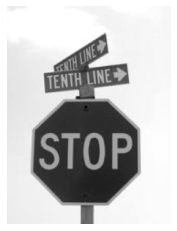

In [31]:
#!/bin/python3

import cv2 as cv
import matplotlib.pyplot as plt

# First 51 imgs are semaphores
image = cv.imread('dataset/images/road52.png', cv.IMREAD_COLOR)

def show_image(image, title=""):
    if (len(image.shape) == 3):
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        cmap = None
    else:
        cmap = "gray"
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

show_image(image)